In [1]:
import pandas as pd
import numpy as np
import random
import math
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics.pairwise import cosine_similarity
import time

from functions import train_test

In [2]:
rating_df = pd.read_csv('data/user_rating_pt.csv')
rating_df.columns = rating_df.columns.astype(int)

In [3]:
rating_treshold = 3.5

rating_df[rating_df < rating_treshold] = 0
rating_df[rating_df >= rating_treshold] = 1
rating_df.columns = range(len(rating_df.columns))

In [4]:
rating_matrix = np.array(rating_df)

In [6]:
known = []
rating_matrix = rating_df.to_numpy()

for u in range(rating_df.shape[0]):
    for i in range(rating_df.shape[1]):
        if rating_df.loc[u,i] > 0:
            known.append((u, i))

training, testing = train_test(known, test_size=0.3)

In [7]:
train_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))
test_matrix = np.zeros((rating_matrix.shape[0], rating_matrix.shape[1]))

for u, i in training:
    train_matrix[u][i] = 1

for u, i in testing:
    test_matrix[u][i] = 1

In [22]:
def get_metrics(test_matrix, user_rec):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for u in range(user_rec.shape[0]):
        for i in user_rec[u]:
            if test_matrix[u][i] == 1:
                true_positive+=1
            else:
                false_positive+=1
                
    for u in range(test_matrix.shape[0]):
        for i in range(test_matrix.shape[1]):
            if test_matrix[u][i] == 1 and i not in user_rec[u]:
                false_negative+=1
    
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    F1_score = 2*(precision*recall)/(precision + recall)

    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", F1_score)
    
    return precision, recall, F1_score

In [23]:
def get_recommendations(pred, k=5):
    rec_list = []
    
    for u in range(pred.shape[0]):
        rec = np.argpartition(pred[u],-k)[-k:]
        rec_list.append(rec)
    
    return np.array(rec_list)

## TF-IDF

In [8]:
movie_df = pd.read_csv('ml-latest-small/movies.csv')
genre_list = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
              'Drama' ,'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
              'Sci-Fi', 'Thriller', 'War', 'Western']

movies_rated = pd.read_csv('ml-latest-small/ratings.csv')['movieId'].unique()
movie_df = movie_df[movie_df['movieId'].isin(movies_rated)].reset_index(drop=True)

In [9]:
movie_genres = []
total_genres = []

for index, row in movie_df.iterrows():
    row_genre = row['genres'].split('|')
    movie_genres.append(row_genre)
    
    total_genres.append(len(row_genre))

In [10]:
tf = pd.DataFrame([])

for genre in genre_list:
    tf_genre = []
    
    for movie in movie_genres:
        if genre in movie:
            tf_genre.append(1/len(movie))
        else:
            tf_genre.append(0)
    
    tf[genre] = tf_genre

In [11]:
total_documents = len(movie_df)
idf = []

for genre in genre_list:
    genre_count = 0
    
    for movie in movie_genres:
        if genre in movie:
            genre_count += 1
    
    idf.append(math.log(total_documents/genre_count, 10))

idf = pd.Series(idf, index=genre_list)

In [12]:
tf_idf = tf*idf

In [13]:
sim_matrix = cosine_similarity(tf_idf)
np.fill_diagonal(sim_matrix, 0)

sim_matrix.shape

(9724, 9724)

In [14]:
avg_sim_matrix = []

for user in train_matrix:
    liked_index = np.where(user==1)
    
    if len(liked_index[0]) != 0:
        avg_sim = sim_matrix[liked_index].mean(axis=0)
        avg_sim[liked_index] = 0
    else:
        avg_sim = [0]*train_matrix.shape[1]
    
    avg_sim_matrix.append(avg_sim)
    
avg_sim_matrix = np.array(avg_sim_matrix)

In [15]:
avg_sim_matrix.shape

(610, 9724)

In [19]:
avg_sim_matrix[[1,2]].shape

(2, 9724)

## LREC

In [47]:
def LREC(dataset, reg=1.0, user_list=None, cf_weight=0.5):
    
    if user_list == None:
        user_list = range(dataset.shape[0])
        
    X = dataset.T
    Y = X*2 - 1
   
    W = []

    for index in user_list:
        if 1 in Y.T[index] and -1 in Y.T[index]:
            rdg = Ridge(alpha=reg).fit(X, Y.T[index])
            
            W.append(rdg.coef_)
        else:
            W.append(np.zeros(dataset.shape[0]))
    
        
    if user_list == range(dataset.shape[0]):     
        W = np.array(W)
        pred = cf_weight*np.dot(W.T, dataset[user_list]) + avg_sim_matrix

    else:
        W = np.array(W)
        pred = cf_weight*np.dot(W, dataset) + avg_sim_matrix[np.array(user_list)]
        
        
    train_replace = pred.min() - 1
    for index, u in enumerate(user_list):
        user_ratings = dataset[u]
        liked_movies = np.where(user_ratings == 1)[0]
            
        for i in liked_movies:
            pred[index][i] = train_replace
        
    return pred

In [ ]:
import time

In [76]:
t = time.time()
pred_ = LREC(train_matrix, reg=250, cf_weight=8)
user_rec = get_recommendations(pred_, k=15)

get_metrics(test_matrix, user_rec)
print(time.time() - t)

Precision : 0.2523497267759563
Recall : 0.12470969484201998
F1 Score : 0.16692571841677206
54.06572914123535


In [77]:
t = time.time()
pred_1 = LREC(train_matrix, reg=250, cf_weight=8, user_list=[121])
user_rec1 = get_recommendations(pred_1, k=15)
time.time() - t

0.12041592597961426

In [78]:
user_rec1

array([[ 968,  224, 6405,  956, 2637, 2144, 8045,  899, 4607,  895, 3557,
        7022, 3136,  254, 2670]])

In [79]:
user_rec[121]

array([ 968,  224, 6405,  956, 2637, 2144, 8045,  899, 4607,  895, 3557,
       7022, 3136,  254, 2670])

## Testing

In [84]:
weights = [i for i in range(1,11)]
scores = []

for w in weights:
    pred_ = LREC(train_matrix, reg=250, cf_weight=w)
    user_rec = get_recommendations(pred_, k=15)
    
    print("weight =", w)
    scores.append(get_metrics(test_matrix, user_rec))
    print()

weight = 1
Precision : 0.22743169398907104
Recall : 0.11239535511747233
F1 Score : 0.15044279775890115

weight = 2
Precision : 0.24513661202185794
Recall : 0.12114501755333514
F1 Score : 0.16215434664738843

weight = 3
Precision : 0.2514754098360656
Recall : 0.12427761274642182
F1 Score : 0.16634737032351346

weight = 4
Precision : 0.25224043715846994
Recall : 0.12465568458007022
F1 Score : 0.16685342490511476

weight = 5
Precision : 0.25256830601092894
Recall : 0.12481771536591953
F1 Score : 0.16707030544008677

weight = 6
Precision : 0.252896174863388
Recall : 0.12497974615176884
F1 Score : 0.16728718597505876

weight = 7
Precision : 0.2523497267759563
Recall : 0.12470969484201998
F1 Score : 0.16692571841677206

weight = 8
Precision : 0.2523497267759563
Recall : 0.12470969484201998
F1 Score : 0.16692571841677206

weight = 9
Precision : 0.2523497267759563
Recall : 0.12470969484201998
F1 Score : 0.16692571841677206

weight = 10
Precision : 0.25169398907103824
Recall : 0.124385633270321

## Graphs

In [85]:
precision_list = []
recall_list = []
F1_list = []

for s in scores:
    precision_list.append(s[0])
    recall_list.append(s[1])
    F1_list.append(s[2])

In [86]:
import matplotlib.pyplot as plt

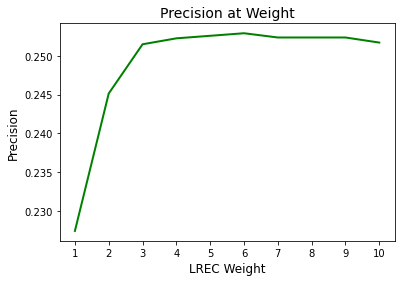

In [95]:
plt.plot(weights, precision_list, color='green', linewidth=2)

plt.title('Precision at Weight', size=14)
plt.xlabel('LREC Weight', size=12)
plt.ylabel('Precision', size=12)
plt.xticks(range(1,11,1))

plt.show()

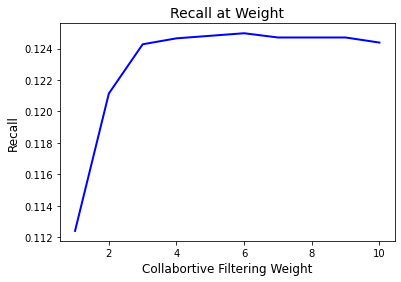

In [93]:
plt.plot(weights, recall_list, color='blue', linewidth=2)

plt.title('Recall at Weight', size=14)
plt.xlabel('Collabortive Filtering Weight', size=12)
plt.ylabel('Recall', size=12)


plt.show()